In [172]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

import random
random.seed(42)

%matplotlib inline

In [173]:
words = open('names.txt', 'r').read().splitlines()
len(words), max(len(w) for w in words), words[:8]

(32033,
 15,
 ['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia'])

In [174]:
start_end_char = '.'

chars = sorted(list(set(''.join(words))))

# Create a mapping from character to index
stoi = {s:i+1 for i, s in enumerate(chars)}
# Add a start and end token
stoi[start_end_char] = 0

# Create a mapping from index to character
itos = {k:s for s, k in stoi.items()}
vocab_size = len(stoi)

stoi, itos, vocab_size

({'a': 1,
  'b': 2,
  'c': 3,
  'd': 4,
  'e': 5,
  'f': 6,
  'g': 7,
  'h': 8,
  'i': 9,
  'j': 10,
  'k': 11,
  'l': 12,
  'm': 13,
  'n': 14,
  'o': 15,
  'p': 16,
  'q': 17,
  'r': 18,
  's': 19,
  't': 20,
  'u': 21,
  'v': 22,
  'w': 23,
  'x': 24,
  'y': 25,
  'z': 26,
  '.': 0},
 {1: 'a',
  2: 'b',
  3: 'c',
  4: 'd',
  5: 'e',
  6: 'f',
  7: 'g',
  8: 'h',
  9: 'i',
  10: 'j',
  11: 'k',
  12: 'l',
  13: 'm',
  14: 'n',
  15: 'o',
  16: 'p',
  17: 'q',
  18: 'r',
  19: 's',
  20: 't',
  21: 'u',
  22: 'v',
  23: 'w',
  24: 'x',
  25: 'y',
  26: 'z',
  0: '.'},
 27)

In [175]:
random.shuffle(words)

In [176]:
# Building the dataset

# context length: how many characters to look at to predict the next one
block_size = 8

def dataset_builder(words):
    X, Y = [], []

    for word in words:
        # print(word)
        context = [0] * block_size
        for c in word + start_end_char:
            ix = stoi[c]
            X.append(context)
            Y.append(ix)
            # print(''.join([itos[i] for i in context]), '--->', c)
            context = context[1:] + [ix] # crop the first element and add the new one

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    # print(X.shape, Y.shape)
    return X, Y

n1 = int(len(words) * 0.8)
n2 = int(len(words) * 0.9)

X, Y = dataset_builder(words[:n1]) # 80% of the data
X_val, Y_val = dataset_builder(words[n1:n2]) # 10% of the data
X_test, Y_test = dataset_builder(words[n2:]) # 10% of the data

In [177]:
for x,y in zip(X[:20], Y[:20]):
    print(''.join([itos[ix.item()] for ix in x]), '--->', itos[y.item()])

........ ---> y
.......y ---> u
......yu ---> h
.....yuh ---> e
....yuhe ---> n
...yuhen ---> g
..yuheng ---> .
........ ---> d
.......d ---> i
......di ---> o
.....dio ---> n
....dion ---> d
...diond ---> r
..diondr ---> e
.diondre ---> .
........ ---> x
.......x ---> a
......xa ---> v
.....xav ---> i
....xavi ---> e


In [178]:
# Let's train a deep neural network

class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5
        self.bias = torch.randn((fan_out)) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
    def __init__(self, dim: int, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x: torch.Tensor):
        # calculate the forward pass
        if x.ndim == 2:
            dim = 0
        elif x.ndim == 3:
            dim = (0, 1)

        if self.training:
            xmean = x.mean(dim, keepdim=True) # batch mean
            xvar = x.var(dim, keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var

        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta

        # Update the buffer
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]


class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []


class Embedding:
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))

    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out

    def parameters(self):
        return [self.weight]


class Flatten:
    def __call__(self, x: torch.Tensor):
        self.out = x.view(x.shape[0], -1)
        return self.out
    
    def parameters(self):
        return []
    

class FlattenConsecutive:
    def __init__(self, n):
        self.n = n

    def __call__(self, x: torch.Tensor):
        B, T, C = x.shape
        x = x.view(B, T // self.n, C * self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out
    
    def parameters(self):
        return []


class Sequential:
    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
    


In [179]:
torch.manual_seed(42)

In [180]:
n_embd = 10
n_hidden = 68

model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])

with torch.no_grad():
    # last layer: make it less confident
    model.layers[-1].weight *= 0.1

parameters = model.parameters()

# same optimization as before
print(sum(p.nelement() for p in parameters)) # number params in total

for p in parameters:
    p.requires_grad = True

22397


In [181]:
ix = torch.randint(0, X.shape[0], (4,))
Xb, Yb = X[ix], Y[ix]
logits = model(Xb)
print(Xb.shape)
Xb

torch.Size([4, 8])


tensor([[ 0,  0,  0,  4,  5, 25, 12,  9],
        [ 0,  0,  0,  0,  0, 11,  8,  1],
        [ 0,  0,  0,  0,  0,  0, 19, 21],
        [ 0,  0,  0,  0,  0,  0,  0,  0]])

In [182]:
for layer in model.layers:
    print(layer.__class__.__name__, ":", layer.out.shape)

Embedding : torch.Size([4, 8, 10])
FlattenConsecutive : torch.Size([4, 4, 20])
Linear : torch.Size([4, 4, 68])
BatchNorm1d : torch.Size([4, 4, 68])
Tanh : torch.Size([4, 4, 68])
FlattenConsecutive : torch.Size([4, 2, 136])
Linear : torch.Size([4, 2, 68])
BatchNorm1d : torch.Size([4, 2, 68])
Tanh : torch.Size([4, 2, 68])
FlattenConsecutive : torch.Size([4, 136])
Linear : torch.Size([4, 68])
BatchNorm1d : torch.Size([4, 68])
Tanh : torch.Size([4, 68])
Linear : torch.Size([4, 27])


In [183]:
model.layers[3].running_mean.shape

torch.Size([1, 1, 68])

In [184]:
e = torch.randn(32, 4, 68)

emean = e.mean((0, 1), keepdim=True) # 1, 1, 68
evar = e.var((0, 1), keepdim=True) # 1, 1, 68

ehat = (e - emean) / torch.sqrt(evar + 1e-5) # 32, 4, 68

ehat.shape

torch.Size([32, 4, 68])

In [185]:
model.layers[0].out.shape

torch.Size([4, 8, 10])

In [186]:
model.layers[1].out.shape

torch.Size([4, 4, 20])

In [187]:
model.layers[2].out.shape 

torch.Size([4, 4, 68])

In [188]:
list(range(10)[1::2])

[1, 3, 5, 7, 9]

In [189]:
e = torch.randn(4, 8, 10)

# Concatenate even and odd just to squeeze the dimensionality 
explicit = torch.cat([e[:, ::2, :], e[:, 1::2, :]], dim=2)
explicit.shape

torch.Size([4, 4, 20])

In [190]:
implicit = e.view(4, 4, -1)
implicit.shape

torch.Size([4, 4, 20])

In [191]:
(implicit == explicit).all()

tensor(True)

In [192]:
# Same optimization as before
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, X.shape[0], (batch_size,))
    Xb, Yb = X[ix], Y[ix] # batch X,Y

    # forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')

    lossi.append(loss.log10().item())

    # if i == 9999:
    #     break


      0/ 200000: 3.5610
  10000/ 200000: 2.0640
  20000/ 200000: 1.8457
  30000/ 200000: 1.8483
  40000/ 200000: 2.1356
  50000/ 200000: 1.6719
  60000/ 200000: 2.0231
  70000/ 200000: 2.2121
  80000/ 200000: 1.9935
  90000/ 200000: 1.6363
 100000/ 200000: 1.7950
 110000/ 200000: 2.6402
 120000/ 200000: 2.0671
 130000/ 200000: 2.0781
 140000/ 200000: 1.9677
 150000/ 200000: 1.7604
 160000/ 200000: 2.0864
 170000/ 200000: 1.8282
 180000/ 200000: 1.9618
 190000/ 200000: 2.0616


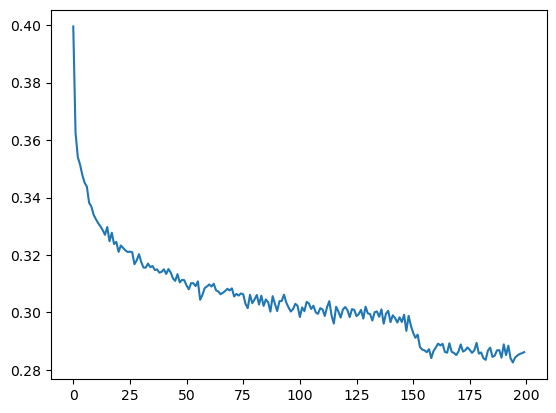

In [193]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [194]:
# put layers into eval mode (needed for batchnorm especially)
for layer in model.layers:
    layer.training = False

In [195]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (X, Y),
        'val': (X_val, Y_val),
        'test': (X_test, Y_test)
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.9110066890716553
val 2.015575885772705


In [196]:
# Sample from the model
for _ in range(20):
    out = []
    context = [0] * block_size

    while True:
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)

        # Sample from the distribution
        ix = torch.multinomial(probs, num_samples=1).item()
        context = context[1:] + [ix]
        out.append(ix)

        # If we generated the end token, stop
        if ix == 0:
            break

    # Decode and print the generated word
    print(''.join([itos[i] for i in out[:-1]]))

jonali
triskay
zion
jareeso
maxtyn
jamechi
shavia
neyel
ellita
averlynn
paill
imarine
swaree
soluv
naen
sandrai
moltimupa
sidelloub
reyara
ekauk


### Baseline

**train:** 1.9184144735336304

**val:** 2.030029296875